# Testing LDMNet over Cifar 10 using Inception features
In this notebook, we run a calssification experiment based on Inception features extracted from the Cifar 10 dataset. 
We use features from the last hidden fully-connected layer. We'll perform classification over these images using :
- softmax classifier
- 1-hidden layer 2048 neurons MLP + dropout
- 1-hidden layer 2048 neurons MLP + LDM regularization

20% of training data is held out as validation for deciding on early stopping neural network training.

In [1]:
%run Cifar10InceptionV3ClusterAndClassify.py

from skorch_utils import MLP, LRScheduler, SaveWeights, EarlyStopping, NaNStopping, NNClassifier, learning_curve
from LDMM import LDMNetSkorch, SaveLDMNetVars
import torch

random_state=0
np.random.seed(random_state)
skf, skf_cv = spliters(random_state, train_size=500, cv_repeats=5)

/mnt/Data/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1635: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Cifar is a dataset of small 32x32 images labeled in 10 categories.

In [2]:
X_imgs, X, y = gen_cifar10()
X = X.astype(np.float32)
y = y.astype(np.int64)

In [3]:
X.shape, y.shape, X_imgs.shape

((60000, 2048), (60000,), (60000, 32, 32, 3))

In [4]:
train, test = next(skf.split(X,y))

## Softmax classifier
Here is the performance of a softmax classifier trained over this features, for reference.

In [5]:
from sklearn.linear_model import LogisticRegression
softmax = LogisticRegression(multi_class='multinomial', solver='lbfgs').fit(X[train], y[train])

/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:712: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [6]:
"train acc", softmax.score(X[train], y[train]),"test acc", softmax.score(X[test],y[test])

('train acc', 1.0, 'test acc', 0.725)

## Simple NN
Here is the performance of the simple MLP + dropout, together with its learning curve.

In [8]:
torch.manual_seed(random_state)
module = MLP(n_in=X.shape[1], num_units=(2048), n_out=10, drop_proba=0.5)
simple_model = NNClassifier(
    module,
    batch_size=500,
    max_epochs=300,
    lr=0.005,
    device='cuda',
    verbose=1,
    callbacks=[
        EarlyStopping(10, 'valid_loss'), 
        NaNStopping(), 
        LRScheduler('ReduceLROnPlateau'), 
        SaveWeights(every_n_epochs=2)]
)

In [9]:
simple_model.fit(X[train], y[train])

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3984       0.1300        2.2992  0.0227
      2        2.3441       0.1600        2.2675  0.0168
      3        2.2883       0.1800        2.2404  0.0162
      4        2.2498       0.1800        2.2158  0.0195
      5        2.2314       0.2200        2.1933  0.0173
      6        2.1905       0.2500        2.1720  0.0191
      7        2.1808       0.2700        2.1510  0.0181
      8        2.1567       0.2900        2.1305  0.0211
      9        2.1259       0.3000        2.1106  0.0182
     10        2.0838       0.3300        2.0909  0.0192
     11        2.0633       0.3500        2.0716  0.0188
     12        2.0206       0.3900        2.0521  0.0182
     13        2.0032       0.3900        2.0333  0.0192
     14        1.9807       0.4200        2.0153  0.0183
     15        1.9514       0.4400        1.9967  0.0172
     16        1.9371       0.4

    109        0.8177       0.7100        1.1953  0.0179
    110        0.8184       0.7100        1.1922  0.0182
    111        0.8093       0.7100        1.1890  0.0204
    112        0.7990       0.7100        1.1863  0.0156
    113        0.8071       0.7100        1.1835  0.0184
    114        0.7961       0.7100        1.1805  0.0157
    115        0.7974       0.7100        1.1779  0.0186
    116        0.7900       0.7100        1.1754  0.0167
    117        0.7928       0.7100        1.1732  0.0207
    118        0.7748       0.7100        1.1706  0.0185
    119        0.7794       0.7100        1.1681  0.0184
    120        0.7658       0.7000        1.1660  0.0187
    121        0.7514       0.7000        1.1632  0.0182
    122        0.7599       0.7100        1.1611  0.0196
    123        0.7479       0.7000        1.1588  0.0158
    124        0.7391       0.7000        1.1561  0.0176
    125        0.7490       0.7100        1.1531  0.0166
    126        0.7402       0.7

    227        0.4590       0.7100        1.0381  0.0190
    228        0.4575       0.7100        1.0372  0.0214
    229        0.4636       0.7100        1.0365  0.0196
    230        0.4569       0.7000        1.0366  0.0171
    231        0.4517       0.7100        1.0364  0.0209
    232        0.4590       0.7000        1.0366  0.0157
    233        0.4595       0.7000        1.0358  0.0192
    234        0.4512       0.7100        1.0348  0.0158
    235        0.4580       0.7200        1.0347  0.0195
    236        0.4498       0.7100        1.0347  0.0193
    237        0.4409       0.7100        1.0339  0.0172
    238        0.4422       0.7100        1.0342  0.0173
    239        0.4403       0.7100        1.0341  0.0177
    240        0.4495       0.7000        1.0339  0.0192
    241        0.4522       0.7100        1.0328  0.0175
    242        0.4348       0.7000        1.0327  0.0211
    243        0.4451       0.7000        1.0322  0.0203
    244        0.4240       0.7

<class 'skorch_utils.NNClassifier'>[initialized](
  module_=MLP(
    (hidden1): Linear(in_features=2048, out_features=2048, bias=True)
    (dropout): Dropout(p=0.5)
    (output): Linear(in_features=2048, out_features=10, bias=True)
  ),
)

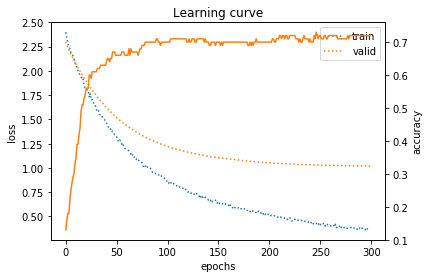

In [12]:
learning_curve(simple_model)

In [13]:
print("train accuracy:", simple_model.score(X[train],y[train]))
print("valid accuracy: ", simple_model.history[-1]['valid_acc'])
print("test accuracy:", simple_model.score(X[test],y[test]))

train accuracy: 0.93
valid accuracy:  0.72
test accuracy: 0.741


## LDMNet
Here we train LDMNet based on the same MLP as before. Again, learning curve and accuracy are shown.

In [15]:
torch.manual_seed(random_state)
module = MLP(n_in=X.shape[1], num_units=(2048), n_out=10, drop_proba=0)
model = LDMNetSkorch(
    module,
    layer_name='hidden1',
    batch_size=500,
    max_epochs=300,
    lr=0.005,
    mu=1e-3,
    lambda_bar=0.01,
    device='cuda',
    verbose=1,
    callbacks=[
        EarlyStopping(10, 'valid_loss'), 
        NaNStopping(), 
        LRScheduler('ReduceLROnPlateau'), 
        SaveWeights(every_n_epochs=10),
        SaveLDMNetVars(every_n_epochs=10)]
)

In [17]:
import os
DIR = 'Cifar10LDMNetExplore'
FILE = 'save.pkl'
overwrite=False
os.makedirs(DIR, exist_ok=True)
fname = os.path.join(DIR, FILE)
if not os.path.exists(fname) or overwrite:
    model.fit(X[train], y[train], X_imgs[train].reshape(train.size,-1))
    pd.to_pickle({'model': model, 'split' :(train,test)}, fname)
else:
    print('Loading...')
    saved = pd.read_pickle(fname)
    model = saved['model']
    train, test = saved['split']

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3501       0.1300        2.3002  0.0598
      2        2.2982       0.1700        2.2682  0.0372
      3        2.2570       0.1400        2.2422  0.0352
      4        2.2209       0.2100        2.2180  0.0422
      5        2.1885       0.2100        2.1961  0.0326
      6        2.1577       0.2500        2.1744  0.0364
      7        2.1286       0.2800        2.1541  0.0328
      8        2.1000       0.3000        2.1334  0.0384
      9        2.0726       0.3200        2.1139  0.0325
     10        2.0454       0.3400        2.0940  0.0375
     11        2.0191       0.3800        2.0753  0.0323
     12        1.9929       0.3900        2.0560  0.0379
     13        1.9675       0.3900        2.0379  0.0327
     14        1.9422       0.4100        2.0192  0.0379
     15        1.9177       0.4600        2.0017  0.0343
     16        1.8933       0.5

    106        0.8050       0.7000        1.2513  0.0350
    107        0.8002       0.7000        1.2495  0.0323
    108        0.7949       0.7000        1.2464  0.0383
    109        0.7902       0.7000        1.2448  0.0322
    110        0.7850       0.6900        1.2419  0.0378
    111        0.7806       0.7000        1.2403  0.1179
    112        0.7755       0.7000        1.2375  0.0408
    113        0.7711       0.7000        1.2360  0.0322
    114        0.7662       0.7000        1.2333  0.0410
    115        0.7620       0.7000        1.2320  0.0326
    116        0.7572       0.7000        1.2294  0.0414
    117        0.7531       0.7000        1.2282  0.0330
    118        0.7484       0.7100        1.2257  0.0389
    119        0.7444       0.7100        1.2246  0.0321
    120        0.7398       0.7100        1.2221  0.0372
    121        0.7360       0.7100        1.2211  0.0327
    122        0.7315       0.7100        1.2188  0.0382
    123        0.7278       0.7

### Observing LDMNet training

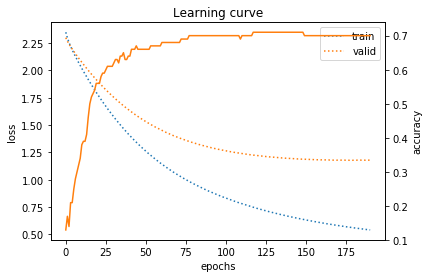

In [18]:
learning_curve(model)

In [14]:
print("train accuracy:", model.score(X[train],y[train]))
print("valid accuracy: ", model.history[-1]['valid_acc'])
print("test accuracy:", model.score(X[test],y[test]))

train accuracy: 0.908
valid accuracy:  0.7
test accuracy: 0.737


#### PCA plots of feature space ksi¶
Here we plot 2D - PCA views of the hidden layer activations -- ksi-- and of the perturbed coordinate functions alpha to which they are regularized, as the iterations proceed.

In [25]:
%run LDMM_plot_utils.py

In [20]:
_=plot_over_time(model,'ksi', y=y[train], cmap='tab10', every_n=1)

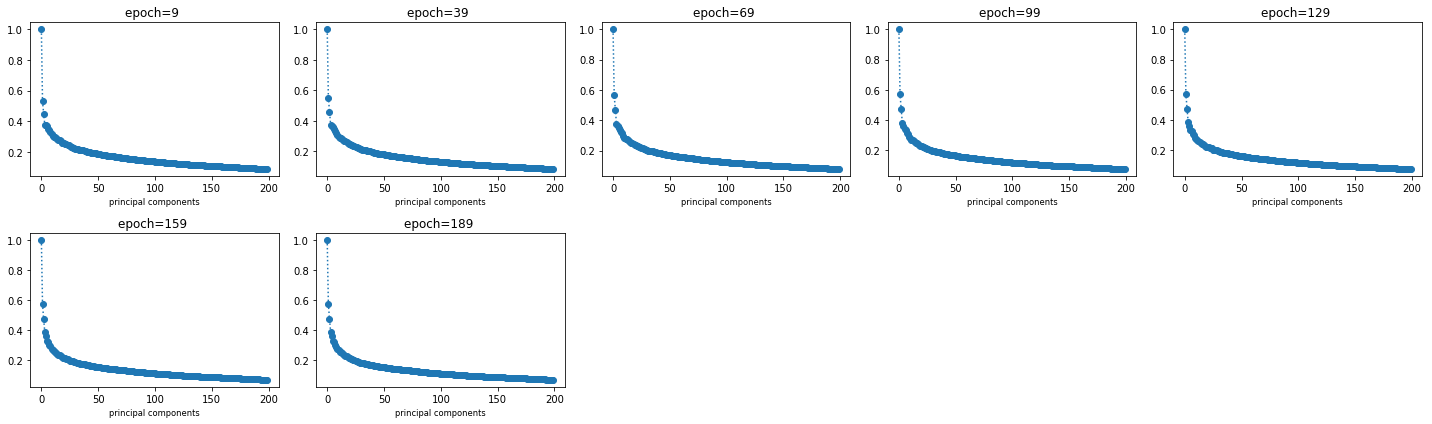

In [28]:
_ = plot_sv_over_time(model, 'ksi', n_components=200)

In this plot, the PCA is calculated at each time step for `alpha` and the same projection is used to plot `ksi`. The idea is to see in a common space how different were `ksi` and `alpha` during the optimization.

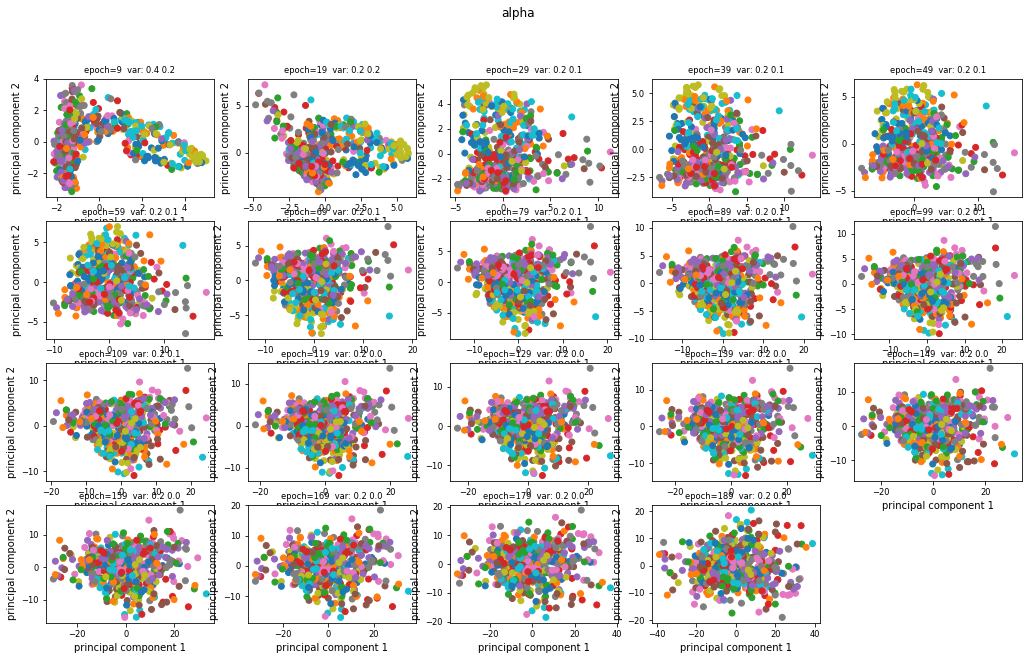

In [17]:
_ = plot_ksi_alpha_time(model, y=y[train], cmap='tab10', every_n=1)

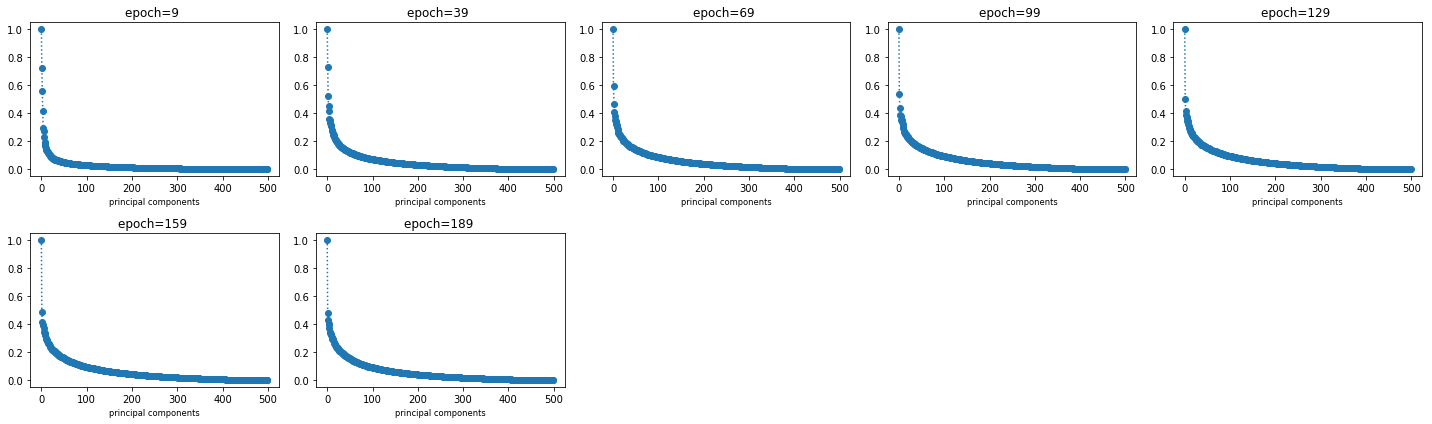

In [24]:
_ = plot_sv_over_time(model, 'alpha')

#### Average values per feature along the iterations
To get a sense of the convergence, here we plot average values per feature (i.e. per neuron of the hidden layer) of : 
- `alpha`
- dual variable `Z`
- activations `ksi`
- weights and bias of the hidden and output layers

We also plot their variations -- delta -- along the iterations. A smothing window is used for delta `alpha` and delta `Z`.
##### Evolution of Z, alpha and ksi

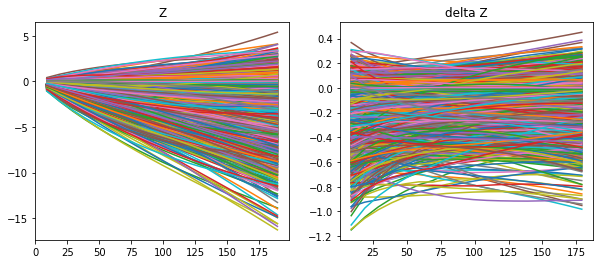

In [18]:
plot_ldmm_vars(model, 'Z')

In [19]:
plot_ldmm_vars(model, 'alpha')

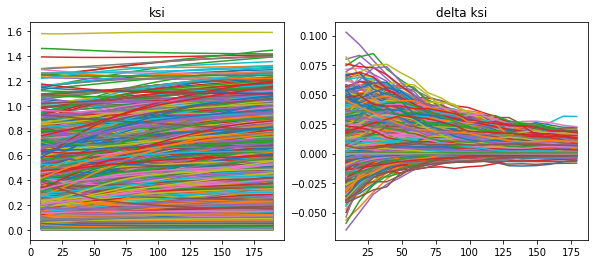

In [20]:
plot_ldmm_vars(model, 'ksi')

##### Evolution of weights and bias 

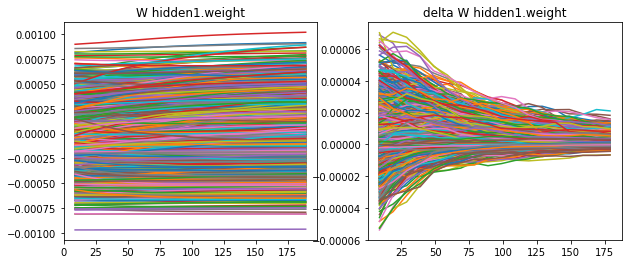

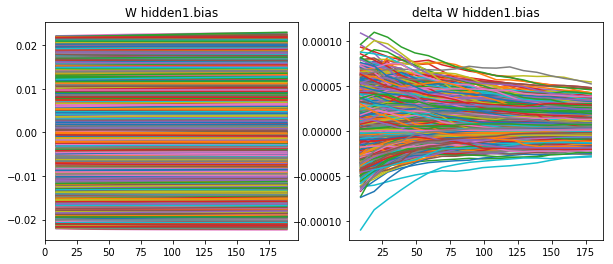

In [21]:
plot_net_weights(model,'hidden1')

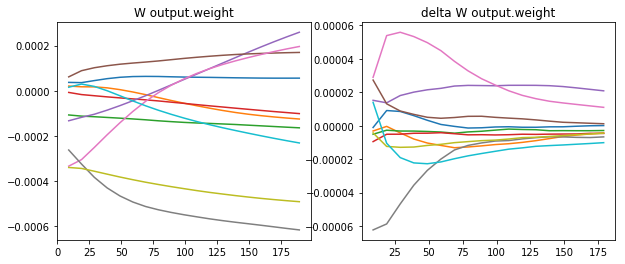

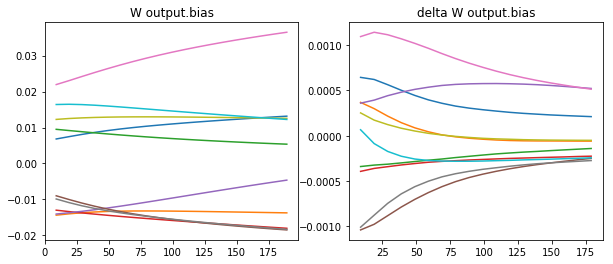

In [22]:
plot_net_weights(model,'output')

### LDMNet over varying training set sizes
Bellow, validation and test accuracies for LDMNet trained over smaller training set sizes.

In [23]:
from copy import deepcopy
models = []
trains = []
for train_size in [100,200,300]:
    skf, skf_cv = spliters(random_state, train_size=train_size, cv_repeats=1)
    train, test = next(skf.split(X,y))
    this_model = deepcopy(model)
    this_model.set_params(verbose=0, batch_size=train_size)
    this_model.set_params(callbacks__EarlyStopping__n_iter_no_change=10)
    this_model = this_model.fit(X[train],y[train],X_imgs[train].reshape(train.size,-1))
    models.append(this_model)
    trains.append(train)

/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1635: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Early stopping @  14


/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1635: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Early stopping @  12


/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1635: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Early stopping @  12


In [24]:
for amodel, atrain in zip(models, trains):
    print("@ %d training samples" % len(atrain))
    print("train accuracy:", model.score(X[atrain],y[atrain]))
    print("valid accuracy:", amodel.history[-1]['valid_acc'])
    print("test accuracy :", amodel.score(X[test],y[test]))


@ 100 training samples
train accuracy: 0.92
valid accuracy: 0.9
test accuracy : 0.7369
@ 200 training samples
train accuracy: 0.89
valid accuracy: 0.875
test accuracy : 0.738
@ 300 training samples
train accuracy: 0.9
valid accuracy: 0.9333333333333333
test accuracy : 0.7408
